# Netflix 

## Load libraries

In [60]:
# Useful starting lines
%matplotlib inline

import numpy as np
import seaborn as sns 
import pandas as pd

from scipy import sparse
from scipy.sparse import csr_matrix

import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

import models as m
import utils as u

from surprise.dataset import * 
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise import BaselineOnly,CoClustering,SVD,SVDpp,NMF,SlopeOne,KNNBasic

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [62]:
raw_data = pd.read_csv('data/data_train.csv', header=0, index_col=0, names=['Id', 'rating'])
data = u.preprocess(raw_data).reset_index().drop(columns=['Id'])

In [64]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",data.shape[0])
print("Total No of Users   :", len(np.unique(data.user)))
print("Total No of movies  :", len(np.unique(data.item)))

Total data 
--------------------------------------------------

Total no of ratings : 1176952
Total No of Users   : 10000
Total No of movies  : 1000


## Surprise models

### Suprise Reader

In [66]:
reader=Reader(rating_scale=(1.0,5.0))
formatted_data= Dataset.load_from_df(data[['user','item','rating']],reader)

In [68]:
67

n_factorsSVD=80
n_epochsSVD=800
lr_allSVD=0.001667
reg_allSVD=0.1

epochs_SVDpp= 30

n_cltr_uCC=13
n_cltr_iCC=13
n_epochsCC=200

bsl_options= {'method': 'als', 'n_epochs': 10, 'reg_u': 15, 'reg_i': 5}

model_parameters_user = {
      'name': 'pearson',
      'user_based': True
    }

k_user=100

model_parameters_movie = {
      'name': 'pearson',
      'user_based': False
    }

k_movie=300

In [70]:
#Split the data
print("Seperating the data in 2 datasets: one for training the models and one for training the blending model:")
trainset, blending_trainset = train_test_split(formatted_data, test_size=.2 ,random_state=1)

Seperating the data in 2 datasets: one for training the models and one for training the blending model:


In [72]:
import utils as u 
df_trainset = u.trainset_from_surprise_to_df(trainset)
ratings = sparse.csr_matrix((df_trainset.Rating.values, (df_trainset.Movie.values,df_trainset.User.values)))
print("The training matrix shape is : (movie, user) : ",ratings.shape)

The training matrix shape is : (movie, user) :  (1000, 10000)


In [74]:
num_items_per_user, num_users_per_item = u.stat_data(ratings)

In [76]:
train, test = m.split_data(ratings, num_items_per_user, num_users_per_item, p_test=0.1)

Total number of nonzero elements in train data:855655
Total number of nonzero elements in test data:85906


In [78]:
print("-Training MF SGD")
user_sgd, movie_sgd = m.matrix_factorization_SGD(train, test)

-Training MF SGD
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0406707832491695.
iter: 1, RMSE on training set: 1.0319200459052986.
iter: 2, RMSE on training set: 1.0234073855331058.
iter: 3, RMSE on training set: 1.0182289781349412.
iter: 4, RMSE on training set: 1.0112441959865646.
iter: 5, RMSE on training set: 1.0076287591183628.
iter: 6, RMSE on training set: 1.0031645255155202.
iter: 7, RMSE on training set: 1.0009344004246836.
iter: 8, RMSE on training set: 0.9982715951812604.
iter: 9, RMSE on training set: 0.9962776414148165.
iter: 10, RMSE on training set: 0.9946291604088592.
iter: 11, RMSE on training set: 0.9933364909883697.
iter: 12, RMSE on training set: 0.9923116667826084.
iter: 13, RMSE on training set: 0.9914241232736605.
iter: 14, RMSE on training set: 0.9909842193152002.
iter: 15, RMSE on training set: 0.990520605617766.
iter: 16, RMSE on training set: 0.9902073248588171.
iter: 17, RMSE on training set: 0.9899859783014069.
iter: 18, RMSE

In [80]:
dfMFSGD=[]

for uid,iid,_ in blending_trainset: #(row,col) => (user,movie)

    user_data = user_sgd[:,uid]  
    movie_data = movie_sgd[:,iid]
            
    prediciton= movie_data @ user_data.T
    
    dfMFSGD.append(prediciton)
dfMFSGD=pd.DataFrame([dfMFSGD])

In [82]:
user_als,movie_als = m.ALS(train, test)


start the ALS algorithm...
RMSE on training set: 1.0096213223343775.
RMSE on training set: 0.9897623997863326.
RMSE on training set: 0.9882554305466034.
RMSE on training set: 0.978581484351724.
RMSE on training set: 0.9655358439160894.
RMSE on training set: 0.9398782693596248.
RMSE on training set: 0.9055869127154887.
RMSE on training set: 0.8821395758380729.
RMSE on training set: 0.8728425787937343.
RMSE on training set: 0.8696054316454426.
RMSE on training set: 0.8680908124294274.
RMSE on training set: 0.8671639919617973.
RMSE on training set: 0.8665206662208798.
RMSE on training set: 0.8660479766196777.
RMSE on training set: 0.8656902166834842.
RMSE on training set: 0.8654147525722969.
RMSE on training set: 0.8652004701576146.
RMSE on training set: 0.8650328133460324.
RMSE on training set: 0.8649012922439742.
RMSE on training set: 0.8647980964022643.
RMSE on training set: 0.8647172652430869.
RMSE on training set: 0.8646541641003647.
RMSE on training set: 0.864605138605641.
RMSE on 

In [84]:
dfMFALS=[]

for uid,iid,_ in blending_trainset: #(row,col) => (user,movie)

    user_data = user_als[:,uid]  
    movie_data = movie_als[:,iid]
            
    prediciton= movie_data @ user_data.T
    
    dfMFALS.append(prediciton)
dfMFALS=pd.DataFrame([dfMFALS])

In [86]:
print("-Training global baseline")
baseline_global=m.baseline_global_mean(train, test)

-Training global baseline
Baseline global RMSE on test:  1.1183490490057637


In [88]:
dfBLGlobal = pd.DataFrame( [baseline_global] *len(blending_trainset) )

In [90]:
print("-Training user baseline")
baseline_user=m.baseline_user_mean(train, test)

-Training user baseline
Baseline User RMSE on test:  1.0952021069845412


In [92]:
dfBLUser = []
for user,movie,_ in blending_trainset:
    dfBLUser.append(baseline_user[0,user])
dfBLUser = pd.DataFrame(dfBLUser)

In [94]:
print("-Training movie baseline")
baseline_movie=m.baseline_movie_mean(train, test)

-Training movie baseline
Baseline Movie RMSE on test:  1.0310268689565203


In [96]:
dfBLMovie = []
for user,movie,_ in blending_trainset:
    dfBLMovie.append(baseline_movie [movie,0])
dfBLMovie = pd.DataFrame(dfBLMovie)  

In [98]:
#Save the label of the second dataset in a dataframe
label_blending_trainset = []

for a,b,c in blending_trainset:
    label_blending_trainset.append(c)

df_label_blending_trainset=pd.DataFrame(label_blending_trainset)

In [100]:
print("-Training CoCluster")
algoCC= CoClustering(n_cltr_i=n_cltr_iCC, n_cltr_u=n_cltr_uCC, n_epochs=n_epochsCC)
algoCC.fit(trainset)

print("-Training Baseline")
algoBL=BaselineOnly(bsl_options=bsl_options)
algoBL.fit(trainset)

print("-Training SVD")
algoSVD=SVD( n_factors=n_factorsSVD, n_epochs=n_epochsSVD, lr_all=lr_allSVD,reg_all=reg_allSVD)
algoSVD.fit(trainset)

print("-Training SVD++")
algoSVDpp = SVDpp(n_factors=n_factorsSVD, n_epochs=epochs_SVDpp, lr_all=lr_allSVD,reg_all=reg_allSVD)
algoSVDpp.fit(trainset)

print("-Training NMF")
algoNMF = NMF(n_factors=n_factorsNMF, n_epochs=n_epochsNMF, reg_pu=reg_puNMF, reg_qi=reg_qiNMF, reg_bu=reg_buNMF, reg_bi=reg_biNMF)
algoNMF.fit(trainset)

print("-Training KNN on movie")
algoKNNMovie =KNNBasic(model_parameters=model_parameters_movie, k=k_movie)
algoKNNMovie.fit(trainset)

print("-Training KNN on user")
algoKNNUser =KNNBasic(model_parameters=model_parameters_user,k=k_user)
algoKNNUser.fit(trainset)

print("-Training Slope One")
algoSO = SlopeOne()
algoSO.fit(trainset)

print("-For the Blending algorithm, we predict on the second dataset using the trained models")
predCC=algoCC.test(blending_trainset)
dfCC=u.pred_from_suprise_to_df(predCC)

predBL=algoBL.test(blending_trainset)
dfBL=u.pred_from_suprise_to_df(predBL)

predSVD=algoSVD.test(blending_trainset)
dfSVD=u.pred_from_suprise_to_df(predSVD)

predSVDpp=algoSVDpp.test(blending_trainset)
dfSVDpp=u.pred_from_suprise_to_df(predSVDpp)

predNMF=algoNMF.test(blending_trainset)
dfNMF=u.pred_from_suprise_to_df(predNMF)

predKNNMovie=algoKNNMovie.test(blending_trainset)
dfKNNMovie=u.pred_from_suprise_to_df(predKNNMovie)

predKNNUser=algoKNNUser.test(blending_trainset)
dfKNNUser=u.pred_from_suprise_to_df(predKNNUser)

predSO=algoSO.test(blending_trainset)
dfSO=u.pred_from_suprise_to_df(predSO)

-Training CoCluster
-Training Baseline
Estimating biases using als...
-Training SVD
-Training SVD++
-Training NMF
-Training KNN on movie
Computing the msd similarity matrix...
Done computing similarity matrix.
-Training KNN on user
Computing the msd similarity matrix...
Done computing similarity matrix.
-Training Slope One
-For the Blending algorithm, we predict on the second dataset using the trained models


## Sparse Matrix Training 

In [277]:
sparse_matrix = sparse.csr_matrix((df_trainset.Rating.values, (df_trainset.User.values,df_trainset.Movie.values)))
print("The training matrix shape is : (user, movie) : ",sparse_matrix.shape)

The training matrix shape is : (user, movie) :  (10000, 1000)


In [278]:
users, movies = sparse_matrix.shape
elem = sparse_matrix.count_nonzero()

print("Sparsity of the training matrix : {0} % ".format((1 - (elem / (users * movies))) * 100))

Sparsity of the training matrix : 90.58439 % 


## Rating's averages

### Rating's average over all data

In [279]:
global_average = sparse_matrix.sum() / sparse_matrix.count_nonzero()
print("The average rating over all movies of trainset is : {0} ".format(global_average) )

The average rating over all movies of trainset is : 3.8565276174353014 


### Rating's average per user

In [280]:
print("Computing the rating's average per user")

user_mean = []   #contains the mean rating for user i at index i

for user_index in range(users):
    
        # find the non-zero ratings for each user in the dataset
        ratings = sparse_matrix[user_index, :]
        nonzeros_ratings = ratings[ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_ratings.shape[1] != 0:
            user_mean.append(nonzeros_ratings.mean())
        else:
            user_mean.append(0)

Computing the rating's average per user


### Rating's average per movie

In [281]:
print("Computing the rating's average per movie")

movie_mean = []   #contains the mean rating for movie j at index j

for movie_index in range(movies):
    
        # find the non-zero ratings for each user in the dataset
        ratings = sparse_matrix[:, movie_index]
        nonzeros_ratings = ratings[ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_ratings.shape[1] != 0:
            movie_mean.append(nonzeros_ratings.mean())
        else:
            movie_mean.append(0)

Computing the rating's average per movie


### Similarity Matrix 

In [282]:
# get the indices of  non zero rows(users) from our sparse matrix
row_ind, col_ind = sparse_matrix.nonzero()

row_ind = sorted(set(row_ind))   #to have unique values and sorted if needed  
col_ind = sorted(set(col_ind))

#### User-User similarity 

In [283]:
top = 5 
print("Computing top",top,"similar user for each user")

Computing top 5 similar user for each user


In [284]:
user_simil_matrix = []

for row in row_ind: 
    # get the similarity row for this user with all other users
    simil = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
    
    # get the index of the top 5 
    top_users = np.argsort((simil))[::-1][1:top+1]
    user_simil_matrix.append(top_users)

#### Movie-Movie similarity

In [285]:
top = 5 
print("Computing top",top,"similar movie for each movie")

Computing top 5 similar movie for each movie


In [286]:
movie_simil_matrix = []

for col in col_ind: 
    # get the similarity col for this movie with all other movies
    simil = cosine_similarity(sparse_matrix.getcol(col).T, sparse_matrix.T).ravel()
    # get the index of the top 5 
    top_movies = np.argsort((simil))[::-1][1:top+1]
    movie_simil_matrix.append(top_movies)

### Featurizing the trainset

Global_Average : Average rating of all the ratings
 
User_Average : User's Average rating

Movie_Average : Average rating of this movie

Similar users rating of this movie:
SimUser1, SimUser2, SimUser3, SimUser4, SimUser5 ( top 5 similar users who rated that movie.. )

Similar movies rated by this user:
SimMovie1, SimMovie2, SimMovie3, SimMovie4, SimMovie5 ( top 5 similar movies rated by this user.. )

In [287]:
row_ind, col_ind = sparse_matrix.nonzero()

In [288]:
df_featured_data = pd.DataFrame({'User': row_ind, 'Movie' : col_ind, 'Grade' : sparse_matrix.data, 'Global_Average' : global_average })

In [289]:
df_featured_data['User_Average'] = df_featured_data['User'].map(lambda x: user_mean[x])
df_featured_data['Movie_Average'] = df_featured_data['Movie'].map(lambda x: movie_mean[x])

Get the indices of the similar users

In [290]:
df_featured_data['SimUser1'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][0]))
df_featured_data['SimUser2'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][1]))
df_featured_data['SimUser3'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][2]))
df_featured_data['SimUser4'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][3]))
df_featured_data['SimUser5'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][4]))

For each similar user need to find the rating that he put for that movie if not available put the average rating of that user as an estimator. 

In [291]:
def Userfunction1(row):
    if(sparse_matrix[row['SimUser1'],row['Movie']] == 0):
        return user_mean[int(row['SimUser1'])]
    else:
        return sparse_matrix[row['SimUser1'],row['Movie']]

In [292]:
df_featured_data['SimUser1'] = df_featured_data.apply(Userfunction1,axis=1)

In [293]:
def Userfunction2(row):
    if(sparse_matrix[row['SimUser2'],row['Movie']] == 0):
        return user_mean[int(row['SimUser2'])]
    else:
        return sparse_matrix[row['SimUser2'],row['Movie']]

In [294]:
df_featured_data['SimUser2'] = df_featured_data.apply(Userfunction2,axis=1)

In [295]:
def Userfunction3(row):
    if(sparse_matrix[row['SimUser3'],row['Movie']] == 0):
        return user_mean[int(row['SimUser3'])]
    else:
        return sparse_matrix[row['SimUser3'],row['Movie']]

In [296]:
df_featured_data['SimUser3'] = df_featured_data.apply(Userfunction3,axis=1)

In [297]:
def Userfunction4(row):
    if(sparse_matrix[row['SimUser4'],row['Movie']] == 0):
        return user_mean[int(row['SimUser4'])]
    else:
        return sparse_matrix[row['SimUser4'],row['Movie']]

In [298]:
df_featured_data['SimUser4'] = df_featured_data.apply(Userfunction4,axis=1)

In [299]:
def Userfunction5(row):
    if(sparse_matrix[row['SimUser5'],row['Movie']] == 0):
        return user_mean[int(row['SimUser5'])]
    else:
        return sparse_matrix[row['SimUser5'],row['Movie']]

In [300]:
df_featured_data['SimUser5'] = df_featured_data.apply(Userfunction5,axis=1)

Get the indices of the similar movies

In [301]:
df_featured_data['SimMovie1'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][0]))
df_featured_data['SimMovie2'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][1]))
df_featured_data['SimMovie3'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][2]))
df_featured_data['SimMovie4'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][3]))
df_featured_data['SimMovie5'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][4]))

For each similar movie we need to find the rating that the user has given to it if not available give the similar movie average rating.  

In [302]:
def Moviefunction1(row):
    if(sparse_matrix[row['User'],row['SimMovie1']] == 0):
        return movie_mean[int(row['SimMovie1'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie1']]

In [303]:
df_featured_data['SimMovie1'] = df_featured_data.apply(Moviefunction1,axis=1)

In [304]:
def Moviefunction2(row):
    if(sparse_matrix[row['User'],row['SimMovie2']] == 0):
        return movie_mean[int(row['SimMovie2'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie2']]

In [305]:
df_featured_data['SimMovie2'] = df_featured_data.apply(Moviefunction2,axis=1)

In [306]:
def Moviefunction3(row):
    if(sparse_matrix[row['User'],row['SimMovie3']] == 0):
        return movie_mean[int(row['SimMovie3'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie3']]

In [307]:
df_featured_data['SimMovie3'] = df_featured_data.apply(Moviefunction3,axis=1)

In [308]:
def Moviefunction4(row):
    if(sparse_matrix[row['User'],row['SimMovie4']] == 0):
        return movie_mean[int(row['SimMovie4'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie4']]

In [309]:
df_featured_data['SimMovie4'] = df_featured_data.apply(Moviefunction4,axis=1)

In [310]:
def Moviefunction5(row):
    if(sparse_matrix[row['User'],row['SimMovie5']] == 0):
        return movie_mean[int(row['SimMovie5'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie5']]

In [311]:
df_featured_data['SimMovie5'] = df_featured_data.apply(Moviefunction5,axis=1)

### Featurizing the blending trainset

In [312]:
df_blending_trainset=[]

for u,m,r in blending_trainset:
    df_blending_trainset.append([u,m,r])
    
df_featured_blending_trainset = pd.DataFrame(df_blending_trainset)
df_featured_blending_trainset = df_featured_blending_trainset.rename({0:'User',1:'Movie',2:'Rating'},axis =1)

In [313]:
df_featured_blending_trainset['User_Average'] = df_featured_blending_trainset['User'].map(lambda x: user_mean[x])
df_featured_blending_trainset['Movie_Average'] = df_featured_blending_trainset['Movie'].map(lambda x: movie_mean[x])

Get the indices of the similar users

In [314]:
df_featured_blending_trainset['SimUser1'] = df_featured_blending_trainset['User'].map(lambda x: int(user_simil_matrix[x][0]))
df_featured_blending_trainset['SimUser2'] = df_featured_blending_trainset['User'].map(lambda x: int(user_simil_matrix[x][1]))
df_featured_blending_trainset['SimUser3'] = df_featured_blending_trainset['User'].map(lambda x: int(user_simil_matrix[x][2]))
df_featured_blending_trainset['SimUser4'] = df_featured_blending_trainset['User'].map(lambda x: int(user_simil_matrix[x][3]))
df_featured_blending_trainset['SimUser5'] = df_featured_blending_trainset['User'].map(lambda x: int(user_simil_matrix[x][4]))

For each similar user need to find the rating that he put for that movie if not available put the average rating of that user as an estimator. 

In [315]:
df_featured_blending_trainset['SimUser1'] = df_featured_blending_trainset.apply(Userfunction1,axis=1)
df_featured_blending_trainset['SimUser2'] = df_featured_blending_trainset.apply(Userfunction2,axis=1)
df_featured_blending_trainset['SimUser3'] = df_featured_blending_trainset.apply(Userfunction3,axis=1)
df_featured_blending_trainset['SimUser4'] = df_featured_blending_trainset.apply(Userfunction4,axis=1)
df_featured_blending_trainset['SimUser5'] = df_featured_blending_trainset.apply(Userfunction5,axis=1)

In [316]:
df_featured_blending_trainset['SimMovie1'] = df_featured_blending_trainset['Movie'].map(lambda x: int(movie_simil_matrix[x][0]))
df_featured_blending_trainset['SimMovie2'] = df_featured_blending_trainset['Movie'].map(lambda x: int(movie_simil_matrix[x][1]))
df_featured_blending_trainset['SimMovie3'] = df_featured_blending_trainset['Movie'].map(lambda x: int(movie_simil_matrix[x][2]))
df_featured_blending_trainset['SimMovie4'] = df_featured_blending_trainset['Movie'].map(lambda x: int(movie_simil_matrix[x][3]))
df_featured_blending_trainset['SimMovie5'] = df_featured_blending_trainset['Movie'].map(lambda x: int(movie_simil_matrix[x][4]))

For each similar movie we need to find the rating that the user has given to it if not available give the similar movie average rating.  

In [317]:
df_featured_blending_trainset['SimMovie1'] = df_featured_blending_trainset.apply(Moviefunction1,axis=1)
df_featured_blending_trainset['SimMovie2'] = df_featured_blending_trainset.apply(Moviefunction2,axis=1)
df_featured_blending_trainset['SimMovie3'] = df_featured_blending_trainset.apply(Moviefunction3,axis=1)
df_featured_blending_trainset['SimMovie4'] = df_featured_blending_trainset.apply(Moviefunction4,axis=1)
df_featured_blending_trainset['SimMovie5'] = df_featured_blending_trainset.apply(Moviefunction5,axis=1)

In [318]:
df_featured_blending_trainset.SimUser1=df_featured_blending_trainset.SimUser1.astype(float)
df_featured_blending_trainset.SimUser2=df_featured_blending_trainset.SimUser2.astype(float)
df_featured_blending_trainset.SimUser3=df_featured_blending_trainset.SimUser3.astype(float)
df_featured_blending_trainset.SimUser4=df_featured_blending_trainset.SimUser4.astype(float)
df_featured_blending_trainset.SimUser5=df_featured_blending_trainset.SimUser5.astype(float)
df_featured_blending_trainset.SimMovie1=df_featured_blending_trainset.SimMovie1.astype(float)
df_featured_blending_trainset.SimMovie2=df_featured_blending_trainset.SimMovie2.astype(float)
df_featured_blending_trainset.SimMovie3=df_featured_blending_trainset.SimMovie3.astype(float)
df_featured_blending_trainset.SimMovie4=df_featured_blending_trainset.SimMovie4.astype(float)
df_featured_blending_trainset.SimMovie5=df_featured_blending_trainset.SimMovie5.astype(float)

In [319]:
df_featured_blending_trainset.drop(['Rating'],inplace=True, axis=1)

In [320]:
#Must save a copy with the "User" and "Movie" columns to be used in predict_on_models
df_featured_blending_trainset_no_user_movie=df_featured_blending_trainset.drop(['User','Movie'], axis=1)

In [160]:
dfMFALS=dfMFALS.transpose()
dfMFSGD=dfMFSGD.transpose()

## xgboosting case

In [239]:
# for xgboosting
df_val=pd.concat([dfCC,dfBL,dfSVD,dfSVDpp,dfNMF,dfKNNMovie,dfKNNUser,dfSO,dfMFSGD,dfMFALS,dfBLGlobal,dfBLMovie, dfBLUser],ignore_index=True,axis=1)
df_val=df_val.rename({0:'dfCC',1:'dfBL',2:'dfSVD',3:'dfSVDpp',4:'dfNMF',5:'dfKNNMovie',6:'dfKNNUser',7:'dfSO',8:'dfMFSGD',9:'dfMFALS',10:'dfBLGlobal',11:'dfBLMovie',12:'dfBLUser'},axis=1)

In [240]:
df_val=pd.concat([df_val,df_featured_blending_trainset_no_user_movie],axis=1)


In [241]:
import xgboost as xgb

model_xgb= xgb.XGBRegressor(silent=True, n_jobs=25, random_state=1,n_estimators=100)

model_xgb.fit(df_val,label_blending_trainset, eval_metric='rmse')


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=25, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, verbosity=1)

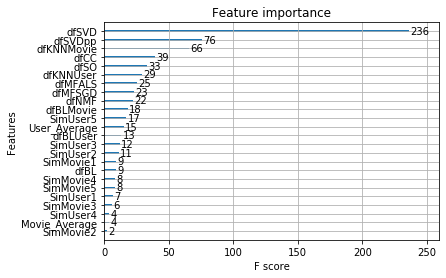

In [242]:
xgb.plot_importance(model_xgb)


In [245]:
# 1.028
import utils as u
ids, preds = u.predict_on_all_models_and_features_xgb(model_xgb,[algoCC, algoBL,algoSVD, algoSVDpp,algoNMF,algoKNNMovie,algoKNNUser,algoSO],
                                          [user_sgd, movie_sgd],[user_als, movie_als],
                                          baseline_global,baseline_movie,baseline_user,df_featured_blending_trainset)



10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000


In [246]:

    
u.create_csv_submission(ids, preds, "submissionBlendedXgbFull.csv")


## Boosting with models only

In [ ]:
# for xgboosting
df_val=pd.concat([dfCC,dfBL,dfSVD,dfSVDpp,dfNMF,dfKNNMovie,dfKNNUser,dfSO,dfMFSGD,dfMFALS,dfBLGlobal,dfBLMovie, dfBLUser],ignore_index=True,axis=1)
df_val=df_val.rename({0:'dfCC',1:'dfBL',2:'dfSVD',3:'dfSVDpp',4:'dfNMF',5:'dfKNNMovie',6:'dfKNNUser',7:'dfSO',8:'dfMFSGD',9:'dfMFALS',10:'dfBLGlobal',11:'dfBLMovie',12:'dfBLUser'},axis=1)

In [ ]:
df_val.head()

In [ ]:
xgbmodel_nofeatures= xgb.XGBRegressor(silent=True, n_jobs=12, random_state=1,n_estimators=100)

xgbmodel_nofeatures.fit(df_val,y_val, eval_metric='rmse')

In [ ]:
xgb.plot_importance(xgbmodel_nofeatures)

In [ ]:
import utils as u
ids, preds = u.predict_on_models_only_xgb([algoCC, algoBL,algoSVD, algoSVDpp,algoNMF,algoKNNMovie,algoKNNUser,algoSO],
                                          [user_sgd, movie_sgd],[user_als, movie_als],
                                          baseline_global,baseline_user,baseline_movie,xgbmodel_nofeatures)

100000


In [254]:
u.create_csv_submission(ids, list_prds, "submissionBlendedxgbModelsOnly.csv")

## Try one model only

In [ ]:
blended all- 1.058
blended surprise only -1.056
blended minimize surprise only -1.061
svdpp-1.059
svd-1.059 (new: 	1.045)
knnuser- 1.074
knnmovie- 1.078
so-1.060

In [293]:
ids, preds =u.predict_on_model(algoSO)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000


In [294]:
u.create_csv_submission(ids, preds, "submissionSO.csv")

## our own Blending case

In [264]:
from sklearn.linear_model import LogisticRegression

df_val=pd.concat([dfCC,dfBL,dfSVD,dfSVDpp,dfNMF,dfKNNMovie,dfKNNUser,dfSO],axis=1)


# model = LogisticRegression(multi_class='multinomial',solver ='newton-cg')
model = LogisticRegression(multi_class='ovr')
model.fit(df_val,y_val)
print("Check classes:",model.classes_)
print(model.coef_)



//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Check classes: [1. 2. 3. 4. 5.]
[[-1.07464777e+00  1.11139912e+00  2.02967935e-02 -1.76004308e+00
   4.53604552e-02 -5.67844678e-02 -2.86790739e-01 -8.72718902e-02]
 [-7.55730329e-01  1.26797560e+00  1.24639501e-01 -1.30559942e+00
  -6.10622515e-02  3.39840726e-02 -6.13582985e-01 -4.00109478e-01]
 [-2.37027135e-01  1.11634339e+00  3.51167167e-01 -6.77209722e-01
  -1.82977835e-01 -1.44300218e-01 -2.84786797e-01 -1.07338172e+00]
 [ 8.34977113e-01 -1.54381693e-02  1.14898049e+00 -1.36206374e-03
  -1.33880948e-01  1.41087381e-01 -6.05193457e-02 -1.74475837e+00]
 [-4.28691594e-02 -3.63025516e+00 -9.22476799e-01  1.27349052e+00
   1.59169244e-02  2.08962415e-01  7.20029089e-01  4.32213263e+00]]


In [180]:
ids, preds = u.predict_on_models([algoCC, algoBL,algoSVD, algoSVDpp,algoNMF,algoKNNMovie,algoKNNUser,algoSO],model.coef_)
u.create_csv_submission(ids, preds, "submissionBlended6.csv")

In [268]:
ids, preds = u.predict_on_models2([algoCC, algoBL,algoSVD, algoSVDpp,algoNMF,algoKNNMovie,algoKNNUser,algoSO],model.coef_)
u.create_csv_submission(ids, preds, "submissionBlendedOurs.csv")

KeyboardInterrupt: 

## Blending with minimize

In [393]:
def compute_mse(real_ratings, predictions):
    """
    Computes the Mean Squared Error given the real and the predicted
    ratings.
    Args:
        real_ratings: The actual ratings
        predictions: Ratings predicted by some model
    Returns:
        mse: The Mean Squared Error value
    """
    error_vector = real_ratings - predictions
    return np.mean(error_vector ** 2)

def compute_rmse(real_ratings, predictions):
    """
    Computes the Root Mean Squared Error given the real and the
    predicted ratings.
    Args:
        real_ratings: The actual ratings
        predictions: Ratings predicted by some model
    Returns:
        rmse: The Root Mean Squared Error value
    """
    rmse = np.sqrt(compute_mse(real_ratings, predictions))
    return rmse

In [397]:
weights=[1/8]*8
models_predictions_on_test=[dfCC,dfBL,dfSVD,dfSVDpp,dfNMF,dfKNNMovie,dfKNNUser,dfSO]

In [398]:
def new_blending():
    result = minimize(fun=objective_function,
                          x0=weights,
                          method='SLSQP')
    print(result)
    return result.x

In [399]:
weights

[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]

In [400]:
def objective_function(weights):
        """
        Objective function to be optimized. The function is indeed the Root Mean 
        Squared Error of the weighted combination of prediction results of each model.
        Args:
            weights: A list containing the individual weights of each model
        """
        mixed_models = 0
        for i in range(len(models_predictions_on_test)):
            mixed_models += weights[i] * models_predictions_on_test[i]
        rmse = compute_rmse(df_y_val, mixed_models)
        return rmse

In [401]:
from scipy.optimize import minimize

result=new_blending()

     fun: 0.9859688586733503
     jac: array([ 0.00038352,  0.00032096,  0.00018456,  0.00020836,  0.00034683,
        0.00078002, -0.00021572,  0.00034592])
 message: 'Optimization terminated successfully.'
    nfev: 433
     nit: 43
    njev: 43
  status: 0
 success: True
       x: array([ 0.27168953, -1.34104839, -0.26525366,  0.67424259, -0.0230704 ,
        0.16161937,  0.18755188,  1.34169849])


In [ ]:
ids, preds=u.predict_on_models([algoCC, algoBL,algoSVD, algoSVDpp,algoNMF,algoKNNMovie,algoKNNUser,algoSO],result)

In [ ]:
u.create_csv_submission(ids, preds, "submissionBlendedMinimize1.csv")

### Least squares 

In [261]:
file_name = 'train_set_with_features.pk'
df_val.to_pickle(file_name)  
df = pd.read_pickle(file_name)

In [327]:
df_val.head()

,dfSVD,dfKNNMovie,dfKNNUser,dfMFSGD,dfMFALS,dfBLGlobal,User_Average,Movie_Average
0,3.371351,3.048282,3.159696,4.276182,5.152174,3.8564,4.306667,4.086207
1,3.670139,3.939017,3.797680,2.387449,2.329403,3.8564,4.120690,2.256281
2,4.247168,4.271208,4.177243,4.211417,4.297415,3.8564,4.105590,4.015644
3,3.445036,3.535469,3.506786,4.879998,4.563293,3.8564,4.238683,4.387609
4,4.754083,4.330050,4.281862,2.681285,3.181867,3.8564,3.577778,3.063525


In [326]:
df_val=df_val.drop(columns=['dfCC','dfBL','dfSVDpp','dfNMF','dfSO','dfBLMovie','dfBLUser'])




In [330]:
df_val.head()

,dfSVD,dfKNNMovie,dfKNNUser,dfMFSGD,dfMFALS,dfBLGlobal,User_Average,Movie_Average
0,3.371351,3.048282,3.159696,4.276182,5.152174,3.8564,4.306667,4.086207
1,3.670139,3.939017,3.797680,2.387449,2.329403,3.8564,4.120690,2.256281
2,4.247168,4.271208,4.177243,4.211417,4.297415,3.8564,4.105590,4.015644
3,3.445036,3.535469,3.506786,4.879998,4.563293,3.8564,4.238683,4.387609
4,4.754083,4.330050,4.281862,2.681285,3.181867,3.8564,3.577778,3.063525


In [328]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    w = np.linalg.solve(tx.T.dot(tx), tx.T.dot(y))    
    rmse = np.sqrt(np.average((y - np.dot(tx,w))*(y - np.dot(tx,w))))
    
    return rmse, w

print("Finding coefficients")
rmse,result = least_squares(label_blending_trainset,df_val)




Finding coefficients


In [329]:
result

array([ 1.00465656e+00,  1.87259162e-01, -6.03165682e-02, -6.84052534e-03,
        9.36283461e-03, -1.22357013e-01, -8.70509102e-03, -2.97987625e-04])

In [333]:
df_featured_blending_trainset.head()

,User,Movie,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,6401,913,4.306667,4.086207,4.352941,3.718750,3.711538,3.957746,3.514286,3.849722,3.965099,4.136201,3.836292,4.193197
1,859,897,4.120690,2.256281,3.716216,3.718519,4.007576,4.127517,2.000000,3.065909,3.365751,3.613201,3.333333,3.150997
2,1959,321,4.105590,4.015644,4.000000,5.000000,4.352941,4.071146,4.025381,5.000000,5.000000,4.113134,4.333195,4.127195
3,1009,33,4.238683,4.387609,5.000000,3.971751,5.000000,5.000000,5.000000,5.000000,4.541568,4.365453,4.680135,5.000000
4,7062,130,3.577778,3.063525,3.567568,3.681159,3.038462,3.750000,3.988235,3.919315,3.919913,3.141487,4.413022,3.395090


In [334]:
df_featured=df_featured_blending_trainset.drop(columns=['SimUser1','SimUser2','SimUser3','SimUser4','SimUser5','SimMovie1','SimMovie2','SimMovie3','SimMovie4','SimMovie5'])


In [339]:
df_featured.head()

,User,Movie,User_Average,Movie_Average
0,6401,913,4.306667,4.086207
1,859,897,4.120690,2.256281
2,1959,321,4.105590,4.015644
3,1009,33,4.238683,4.387609
4,7062,130,3.577778,3.063525


In [365]:
features_row = df_featured[(df_featured.Movie == 913) ].drop(['User','Movie'],axis = 1 )


In [367]:
features_row.values[0][1]

4.086206896551724

In [344]:
surprise_weights = result[:3]
model_weight = {'MFSGD' : result[3] , 'MFALS' :result[4], 'BLGlobal' :result[5],
                'User_Average' : result[6], 'Movie_Average' : result[7] }

In [352]:
df_featured.head()

,User,Movie,User_Average,Movie_Average
0,6401,913,4.306667,4.086207
1,859,897,4.120690,2.256281
2,1959,321,4.105590,4.015644
3,1009,33,4.238683,4.387609
4,7062,130,3.577778,3.063525


In [373]:
import utils as u
#1.026
ids, preds=u.predict_on_models([algoSVD,algoKNNMovie,algoKNNUser],
                                 [user_sgd, movie_sgd],[user_als, movie_als],baseline_global,df_featured,global_average,
                                 surprise_weights,model_weight)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000


In [254]:
rmse

0.9817434189969411

In [375]:
u.create_csv_submission(ids, preds, "submissionBlendedLS4.csv")